In [1]:
import pyxdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from warnings import warn
import math
from HIL.cost_processing.ECG import ECGComplexity
import neurokit2 as nk

import os
import glob

: 

In [2]:
!pip list

Package                                                 Version      Editable project location
------------------------------------------------------- ------------ --------------------------------------------------
asttokens                                               2.4.1
bleak                                                   0.21.1
botorch                                                 0.10.0
certifi                                                 2024.2.2
charset-normalizer                                      3.3.2
colorama                                                0.4.6
comm                                                    0.2.1
contourpy                                               1.2.0
cycler                                                  0.12.1
debugpy                                                 1.8.1
decorator                                               5.1.1
executing                                               2.0.1
filelock                           

## Export ECG data and acceleration data from xdf file

In [2]:
filename = "sub-P001_ses-S001_task-Default_run-001_eeg.xdf" # File name

data, header = pyxdf.load_xdf(filename)

In [3]:
# # Checking the format of "data" in the xdf file
# data[0] #- ['imu_stream_new']
# data[1] #- ['polar accel'] # acceleration data, with sampling rate = 200 Hz
# data[2] #- ['polar ECG'] # ECG raw data, with sampling rate = 130.14 Hz
# data[3] #- ['TestInf']  # information about conditions
# data[4] #- ['ECG_processed'] # represents the cost function - RMSSD
# data[5] #- ['Walking Speed']
# data[6] #- ['emg_stream_new']

In [3]:
for data_streams in data:
    
    print(data_streams['info']['name'])
    
    if data_streams['info']['name']==['polar ECG 2']:
        ecg_data=data_streams['time_series'] # this is the ecg data
        ecg_time_stamps=data_streams['time_stamps']
        
    if data_streams['info']['name']==['polar accel']:
        accel_data=data_streams['time_series'] # this is the acceleration data
        accel_time_stamps=data_streams['time_stamps']

    if data_streams['info']['name']==['TestInf']:
        condition_data = data_streams['time_series'] # this is the condition data (e.g. "first parameter", "second parameter", etc)
        condition_time_stamps = data_streams['time_stamps']
    
    if data_streams['info']['name']==['Change_parm']:
        parm_data = data_streams['time_series'] 
        parm_time_stamps = data_streams['time_stamps']

['polar accel']
['polar ECG 2']
['ECG_complexity']


In [4]:
ecg_data

array([[ -43.],
       [-105.],
       [ -83.],
       ...,
       [-191.],
       [-146.],
       [-107.]], dtype=float32)

In [5]:
ecg_time_stamps

array([906725.47364741, 906725.48133512, 906725.48902283, ...,
       906965.6454532 , 906965.65314092, 906965.66082863])

In [6]:
accel_data
# sampling rate for acceleration data is 200 Hz

array([[ -883.,   116.,   220.],
       [ -883.,   120.,   220.],
       [ -882.,   126.,   226.],
       ...,
       [ -989.,   -20.,    89.],
       [-1015.,    -9.,   125.],
       [-1054.,    -6.,   143.]], dtype=float32)

In [7]:
x=accel_data.T
x

array([[ -883.,  -883.,  -882., ...,  -989., -1015., -1054.],
       [  116.,   120.,   126., ...,   -20.,    -9.,    -6.],
       [  220.,   220.,   226., ...,    89.,   125.,   143.]],
      dtype=float32)

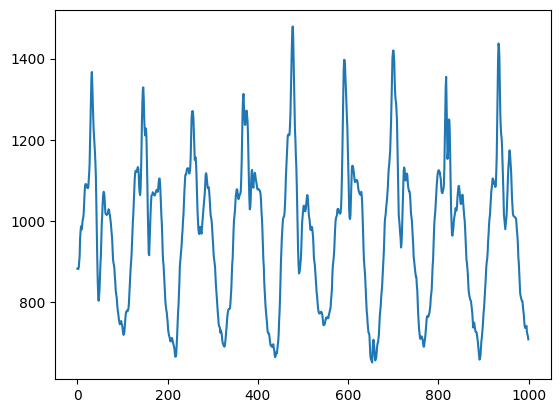

In [8]:
plt.plot(-x[0][0:1000])     # x[0] seems to be vertical acceleration.
# plt.xlim([0, 1000])

In [ ]:
plt.plot(x[2][0:1000])     # x[2] seems to be forward-backward acceleration
# plt.xlim([0, 1000])

In [30]:
x[0]

array([ -883.,  -883.,  -882., ...,  -989., -1015., -1054.], dtype=float32)

In [9]:
# Check duration
sampling_rate = 200 # Hz
duration = len(accel_data)/sampling_rate
duration # in seconds

241.56

## Extract stride intervals from acceleration data

In [10]:
## Use find_peaks function in Python
# peaks, _ = signal.find_peaks(-x[0], height=1250, distance=75)  # Vertical acceleration - Adjust the height parameter as needed
peaks, _ = signal.find_peaks(-x[2], height=200, distance=75)  # Forward-aft acceleration - Adjust the height parameter as needed



# Calculate intervals between peaks (in samples)
intervals = np.diff(peaks)

In [33]:
len(intervals)

418

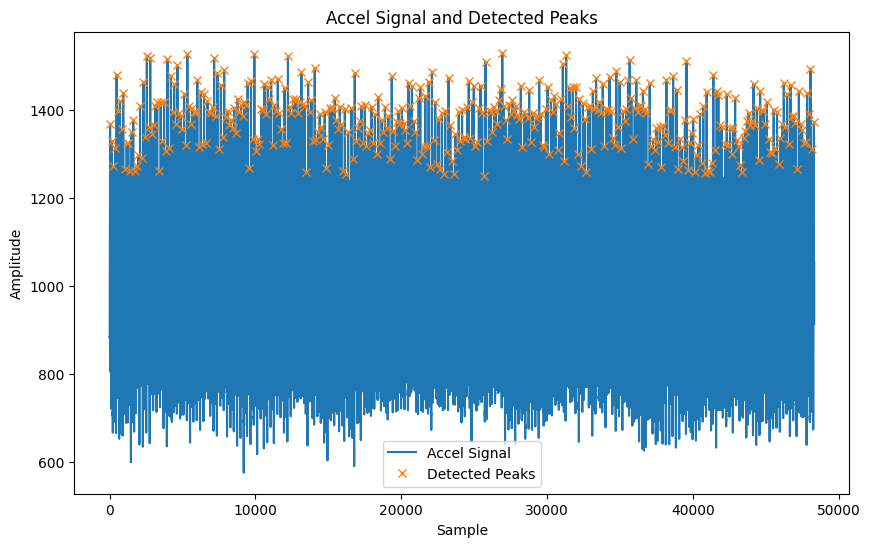

In [12]:
# Acceleration in the vertical direction
plt.figure(figsize=(10, 6))
plt.plot(-x[0], label='Accel Signal')
plt.plot(peaks, -x[0][peaks], "x", label='Detected Peaks')
plt.legend()
plt.title('Accel Signal and Detected Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
#Acceleration in the forward-aft direction
plt.figure(figsize=(10, 6))
plt.plot(-x[2], label='Accel Signal')
plt.plot(peaks, -x[2][peaks], "x", label='Detected Peaks')
plt.legend()
plt.title('Accel Signal and Detected Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [16]:
sampling_rate

200

In [37]:
range(0, len(intervals) - 2, 2)

range(0, 416, 2)

In [51]:
stride_times_left = []
stride_times_right =  []
step_time_left = []
step_time_right = []

for i in range(0, len(intervals) - 2, 2):
    print(i)
    stride_times_left.append(intervals[i] + intervals[i+1])
    stride_times_right.append(intervals[i+1] + intervals[i+2])
    step_time_left.append(intervals[i]/sampling_rate)
    step_time_right.append(intervals[i+1]/sampling_rate)
stride_times_left = np.array(stride_times_left)
stride_times_right = np.array(stride_times_right)
step_time_left = np.array(step_time_left)
step_time_right = np.array(step_time_right)

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414


In [52]:
step_time_left

array([0.57 , 0.565, 0.57 , 0.585, 0.61 , 0.565, 0.56 , 0.58 , 0.59 ,
       0.6  , 0.59 , 0.59 , 0.605, 0.61 , 0.605, 0.585, 0.57 , 0.58 ,
       0.555, 0.56 , 0.58 , 0.565, 0.58 , 0.575, 0.565, 0.565, 0.585,
       0.565, 0.595, 0.57 , 0.575, 0.58 , 0.58 , 0.585, 0.585, 0.575,
       0.58 , 0.585, 0.595, 0.565, 0.57 , 0.595, 0.595, 0.59 , 0.58 ,
       0.57 , 0.595, 0.565, 0.565, 0.575, 0.585, 0.575, 0.585, 0.59 ,
       0.575, 0.57 , 0.565, 0.575, 0.575, 0.57 , 0.565, 0.57 , 0.565,
       0.55 , 0.595, 0.57 , 0.565, 0.565, 0.555, 0.58 , 0.555, 1.13 ,
       0.55 , 0.575, 0.575, 0.575, 0.58 , 0.58 , 0.58 , 0.59 , 0.575,
       0.58 , 0.58 , 0.59 , 0.585, 0.575, 0.585, 0.575, 0.575, 0.58 ,
       0.605, 0.585, 0.6  , 0.575, 0.575, 0.575, 0.585, 0.565, 0.58 ,
       0.57 , 0.57 , 0.61 , 0.565, 0.58 , 0.575, 0.57 , 0.575, 0.565,
       0.57 , 0.58 , 0.57 , 0.57 , 0.585, 0.59 , 0.565, 0.555, 0.575,
       0.575, 0.565, 0.58 , 0.57 , 0.57 , 0.57 , 0.565, 0.565, 0.565,
       0.565, 0.555,

In [53]:
intervals/200

array([0.57 , 0.545, 0.565, 0.545, 0.57 , 0.545, 0.585, 0.58 , 0.61 ,
       0.565, 0.565, 0.56 , 0.56 , 0.565, 0.58 , 0.58 , 0.59 , 0.585,
       0.6  , 0.58 , 0.59 , 0.56 , 0.59 , 0.58 , 0.605, 0.585, 0.61 ,
       0.58 , 0.605, 0.59 , 0.585, 0.59 , 0.57 , 0.59 , 0.58 , 0.59 ,
       0.555, 0.57 , 0.56 , 0.56 , 0.58 , 0.575, 0.565, 0.565, 0.58 ,
       0.545, 0.575, 0.56 , 0.565, 0.57 , 0.565, 0.575, 0.585, 0.575,
       0.565, 0.575, 0.595, 0.58 , 0.57 , 0.58 , 0.575, 0.555, 0.58 ,
       0.56 , 0.58 , 0.59 , 0.585, 0.565, 0.585, 0.585, 0.575, 0.58 ,
       0.58 , 0.56 , 0.585, 0.55 , 0.595, 0.565, 0.565, 0.555, 0.57 ,
       0.58 , 0.595, 0.56 , 0.595, 0.555, 0.59 , 0.59 , 0.58 , 0.585,
       0.57 , 0.555, 0.595, 0.555, 0.565, 0.57 , 0.565, 0.56 , 0.575,
       0.58 , 0.585, 0.59 , 0.575, 0.57 , 0.585, 0.575, 0.59 , 0.575,
       0.575, 0.575, 0.57 , 0.59 , 0.565, 0.58 , 0.575, 0.59 , 0.575,
       0.56 , 0.57 , 0.565, 0.565, 0.56 , 0.57 , 0.57 , 0.565, 0.58 ,
       0.55 , 0.575,

In [58]:
symmetry_index = abs((2 * (step_time_left - step_time_right) / (step_time_left + step_time_right)) * 100)

In [67]:
avg_symmetry_index = np.abs((2 * (step_time_left.mean() - step_time_right.mean()) / (step_time_left.mean() + step_time_right.mean())) * 100)

In [68]:
avg_symmetry_index

1.037003102679959

In [65]:
symmetry_index.mean()

0.7233793444424459

In [ ]:
# Save data to an Excel file

# Create a DataFrame
df = pd.DataFrame({
    "step_time_left": step_time_left,
    "step_time_right": step_time_right
})

# Save to Excel file
excel_filename = "Polar_accel_step_times.xlsx"
df.to_excel(excel_filename, index=False)

excel_filename